## Install dependencies

In [1]:
# !pip install llama-index llama-index-embeddings-huggingface llama-index-llms-openai llama-index-readers-file llama-index-vector-stores-kdbai llama-index-embeddings-clip
# !pip install 'git+https://github.com/openai/CLIP.git'
# !pip install kdbai_client matplotlib wikipedia tqdm

## Download data

**Libraries**

In [2]:
import os
from tqdm import tqdm
import wikipedia
import urllib.request

**Data directories and paths**

In [3]:
# Root path
root_path = os.path.abspath(os.getcwd())

# Data directory and path
data_dir = "data"
data_path = os.path.join(root_path, data_dir)
if not os.path.exists(data_path):
    os.mkdir(data_path)

**Download data - wikipedia images & texts**

In [4]:
def download_data(WIKI_TITLES, MAX_IMAGES_PER_TITLE):
    # Text metadata
    text_uuid = 0
    text_metadata = dict()
    
    # Image metadata
    image_uuid = 0
    image_metadata = dict()
    
    # Download data - text and images from wiki pages
    for title in tqdm(WIKI_TITLES):
        images_per_wiki_page = 0
        print(title)
        try:
            wiki_page = wikipedia.page(title)

            # Text - data and metadata
            text_uuid += 1
            page_content = wiki_page.content
            
            content_path = os.path.join(data_path, f"{title}.txt")
            with open(content_path, 'w') as f:
                f.write(page_content)
            text_file_name = f"{title}.txt"

            text_metadata[text_uuid] = {
                "filename": text_file_name,
                "file_path": content_path
            }
    
            list_img_urls = wiki_page.images
            for url in list_img_urls:
                if url.endswith(".jpg") or url.endswith(".png"):
                    # Limiting images to downloaded per wikipedia page
                    images_per_wiki_page += 1
                    if images_per_wiki_page > MAX_IMAGES_PER_TITLE:
                        break
    
                    # Image - data and metadata
                    image_uuid += 1
                    image_path = os.path.join(data_path, f"{image_uuid}.jpg")
                    image_file_name = f"{image_uuid}.jpg"
    
                    urllib.request.urlretrieve(
                        url, image_path
                    )
    
                    image_metadata[image_uuid] = {
                        "filename": image_file_name,
                        "file_path": image_path,
                    }
        except Exception:
            print(str(Exception("No images found for Wikipedia page: ")) + title)
            continue

    return image_metadata, text_metadata

In [5]:
# Wikipedia titles to retrieve data & max images per title to retrieve
WIKI_TITLES = [
    "Machiavelli",
    "Beethoven",
    "Burj khalifa",
    "Cherry Blossom",
    "Video Game"
]
MAX_IMAGES_PER_TITLE = 10

# Download the data if not downloaded yet
image_metadata, text_metadata = download_data(WIKI_TITLES, MAX_IMAGES_PER_TITLE)

  0%|                                                     | 0/5 [00:00<?, ?it/s]

Machiavelli


 20%|█████████                                    | 1/5 [00:11<00:45, 11.40s/it]

Beethoven


 40%|██████████████████                           | 2/5 [00:18<00:26,  8.71s/it]

Burj khalifa


 60%|███████████████████████████                  | 3/5 [00:24<00:15,  7.56s/it]

Cherry Blossom


 80%|████████████████████████████████████         | 4/5 [00:38<00:10, 10.08s/it]

Video Game


100%|█████████████████████████████████████████████| 5/5 [01:23<00:00, 16.74s/it]


**Resize Images**

In [6]:
import os
import math
from PIL import Image
from tqdm import tqdm

In [7]:
for file in tqdm(os.listdir(data_path)):
    if file.endswith('.jpg'):
        img_path = os.path.join(data_path, file)
        img = Image.open(img_path)
        img_width, img_height = img.size
        aspect_ratio = img_width/img_height

        if img_width > 2048:
            new_width = 2048
            new_height = round(new_width/aspect_ratio)

            img = img.resize((new_width, new_height))
            img.save(img_path)

100%|███████████████████████████████████████████| 50/50 [00:06<00:00,  7.55it/s]


**Show images**

In [8]:
from PIL import Image
import matplotlib.pyplot as plt
import os

In [9]:
def show_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16,9))
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(3, 3, images_shown+1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 9:
                break

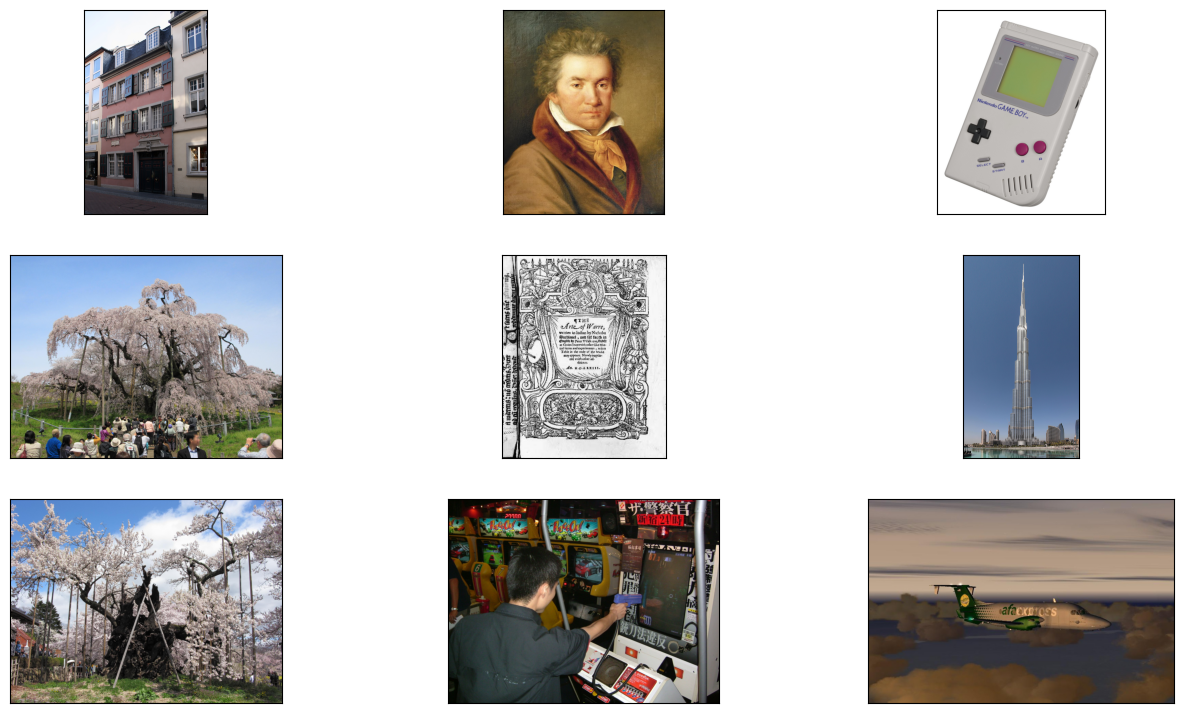

In [10]:
image_paths = []
for file in os.listdir(data_path):
    if file.endswith('.jpg'):
        img_path = os.path.join(data_path, file)
        image_paths.append(img_path)
show_images(image_paths)

**Show texts**

In [11]:
def show_texts(text_paths):
    texts_shown = 0
    for text_path in text_paths:
        if os.path.isfile(text_path):
            with open(text_path, 'r') as text_file:
                content = text_file.read()
            print(content[0:512])
            print("="*80)
    
            texts_shown += 1
            if texts_shown >= 3:
                break

In [12]:
text_paths = []
for file in os.listdir(data_path):
    if file.endswith('.txt'):
        text_path = os.path.join(data_path, file)
        text_paths.append(text_path)
show_texts(text_paths)

Ludwig van Beethoven (baptised 17 December 1770 – 26 March 1827) was a German composer and pianist. He is one of the most revered figures in the history of Western music; his works rank among the most performed of the classical music repertoire and span the transition from the Classical period to the Romantic era in classical music. His early period, during which he forged his craft, is typically considered to have lasted until 1802. From 1802 to around 1812, his middle period showed an individual developme
The cherry blossom, or sakura, is the flower of trees in Prunus subgenus Cerasus. "Sakura" usually refers to flowers of ornamental cherry trees, such as cultivars of Prunus serrulata, not trees grown for their fruit: 14–18  (although these also have blossoms). Cherry blossoms have been described as having a vanilla-like smell, which is mainly attributed to coumarin.
Wild species of cherry tree are widely distributed, mainly in the Northern Hemisphere. They are common in East Asia,  

## KDB.ai session and tables

**Libraries**

In [13]:
import kdbai_client as kdbai

**KDB.ai session**

In [14]:
KDBAI_ENDPOINT = "http://localhost:8085"
session = kdbai.Session(endpoint=KDBAI_ENDPOINT)

**Table for storing Text data**

In [15]:
# Texts table name and schema
text_table_name = "wiki_texts"
text_table_schema = {
    "columns": [
        dict(name="document_id", pytype="bytes"),
        dict(name="text", pytype="bytes"),
        dict(
            name="embedding",
            vectorIndex=dict(type="flat", metric="L2", dims=1536)
        ),
        dict(name="filename", pytype="str"),
        dict(name="file_path", pytype="str"),
    ]
}

In [16]:
# Drop table if exists
if text_table_name in session.list():
    session.table(text_table_name).drop()

In [17]:
# Texts table
texts_table = session.create_table(text_table_name, text_table_schema)

In [18]:
# Show texts table scheme
texts_table.schema()

{'columns': [{'name': 'document_id', 'qtype': 'string', 'pytype': 'bytes'},
  {'name': 'text', 'qtype': 'string', 'pytype': 'bytes'},
  {'name': 'embedding',
   'vectorIndex': {'type': 'flat', 'metric': 'L2', 'dims': 1536},
   'qtype': 'reals',
   'pytype': 'float32'},
  {'name': 'filename', 'qtype': 'symbol', 'pytype': 'str'},
  {'name': 'file_path', 'qtype': 'symbol', 'pytype': 'str'}]}

**Table for storing Image data**

In [19]:
# Image table name and schema
image_table_name = "wiki_imgs"
image_table_schema = {
    "columns": [
        dict(name="document_id", pytype="bytes"),
        dict(name="text", pytype="bytes"),
        dict(
            name="embedding",
            vectorIndex=dict(type="flat", metric="L2", dims=512)
        ),
        dict(name="filename", pytype="bytes"),
        dict(name="file_path", pytype="bytes")
    ]
}

In [20]:
# Drop table if exists
if image_table_name in session.list():
    session.table(image_table_name).drop()

In [21]:
# Images table
imgs_table = session.create_table(image_table_name, image_table_schema)

In [22]:
# Show images table scheme
imgs_table.schema()

{'columns': [{'name': 'document_id', 'qtype': 'string', 'pytype': 'bytes'},
  {'name': 'text', 'qtype': 'string', 'pytype': 'bytes'},
  {'name': 'embedding',
   'vectorIndex': {'type': 'flat', 'metric': 'L2', 'dims': 512},
   'qtype': 'reals',
   'pytype': 'float32'},
  {'name': 'filename', 'qtype': 'string', 'pytype': 'bytes'},
  {'name': 'file_path', 'qtype': 'string', 'pytype': 'bytes'}]}

## Loading data

**Consolidating both image and text metadata**

In [23]:
metadata_dict = dict()

# Adding image metadata to final metadata dictionary
for k, v in image_metadata.items():
    ondisk_file_name = v["file_path"].split('/')[-1]
    metadata_key = f"{data_dir}/{ondisk_file_name}"
    metadata_value = {
        "filename": v["filename"],
        "file_path": f"{data_dir}/{ondisk_file_name}"
    }
    metadata_dict[metadata_key] = metadata_value

# Adding text metadata to final metadata dictionary
for k, v in text_metadata.items():
    ondisk_file_name = v["file_path"].split('/')[-1]
    metadata_key = f"{data_dir}/{ondisk_file_name}"
    metadata_value = {
        "filename": v["filename"],
        "file_path": f"{data_dir}/{ondisk_file_name}"
    }
    metadata_dict[metadata_key] = metadata_value

**Consolidating input paths**

In [24]:
local_files = []
for k in metadata_dict:
    local_files.append(k)
print(len(local_files))

50


**Loading data**

In [25]:
from llama_index.core import SimpleDirectoryReader

In [26]:
def get_metadata(filepath):
    return metadata_dict[filepath]

In [27]:
%%time

documents = SimpleDirectoryReader(input_files=local_files, file_metadata=get_metadata)

docs = documents.load_data()
len(docs)

CPU times: user 19 ms, sys: 12.5 ms, total: 31.5 ms
Wall time: 34 ms


50

## Creating Multi Modal Vector Index for data

**OpenAI API Key for CLIP Embeddings**

In [28]:
import os
from getpass import getpass

In [29]:
os.environ["OPENAI_API_KEY"] = getpass("OpenAI API key: ")

OpenAI API key:  ········


**Create vector store, storage context and the index for retrieval, query purposes**

In [30]:
from llama_index.vector_stores.kdbai import KDBAIVectorStore
from llama_index.core import StorageContext
from llama_index.core import Settings
from llama_index.core.indices import MultiModalVectorStoreIndex
from llama_index.core.node_parser import SentenceSplitter

# Store
text_store = KDBAIVectorStore(texts_table)
image_store = KDBAIVectorStore(imgs_table)

# Storage context
storage_context = StorageContext.from_defaults(
    vector_store=text_store, 
    image_store=image_store,
)

# Settings
Settings.transformations = [SentenceSplitter(chunk_size=500, chunk_overlap=0)]

# Multi Modal Vector Store Index
index = MultiModalVectorStoreIndex.from_documents(
    docs,
    storage_context=storage_context,
)

## Multi Modal Retrieval from user's query

**Using index as retriever**

In [31]:
retriever_engine = index.as_retriever(
    similarity_top_k=1, image_similarity_top_k=3
)

**Retrieve most similar text/image embeddings based on query**

In [32]:
from llama_index.core.response.notebook_utils import display_source_node

def retrieve(retriever_engine, query_str):
    retrieved_results = retriever_engine.retrieve(query_str)

    retrieved_image = []
    retrieved_text = []
    for res_node in retrieved_results:
        if res_node.text == '':
            retrieved_image.append(res_node.node.metadata["file_path"])
        else:
            retrieved_text.append(res_node.text)

    return retrieved_image, retrieved_text

Niccolò di Bernardo dei Machiavelli (3 May 1469 – 21 June 1527) was a Florentine diplomat, author, philosopher, and historian who lived during the Italian Renaissance. He is best known for his political treatise The Prince (Il Principe), written around 1513 but not published until 1532, five years after his death. He has often been called the father of modern political philosophy and political science.
For many years he served as a senior official in the Florentine Republic with responsibilities in diplomat


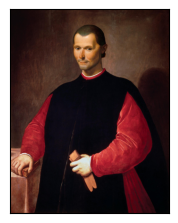

In [33]:
query_str = "Tell me about the machiavelli, where he lived and what he did?"

imgs, txts = retrieve(retriever_engine=retriever_engine, query_str=query_str)

# Show retrieved texts
context_str = "".join(txts)
print(context_str[:512])

# Show retrieved images
show_images(imgs)

## Multi Modal RAG

**Multi Modal Model: GPT-4V**

In [34]:
from llama_index.multi_modal_llms.openai import OpenAIMultiModal

In [35]:
mm_model_name = "gpt-4o"
openai_mm_llm = OpenAIMultiModal(
    model=mm_model_name, api_key=os.environ["OPENAI_API_KEY"], max_new_tokens=1500
)

**Setting Prompt Template and Query Engine for MM-RAG**

In [36]:
from llama_index.core import PromptTemplate
from llama_index.core.query_engine import SimpleMultiModalQueryEngine

In [37]:
qa_tmpl_str = (
    "Context information is below.\n"
    "---------------------\n"
    "{context_str}\n"
    "---------------------\n"
    "Given the context information and not prior knowledge, "
    "answer the query.\n"
    "Query: {query_str}\n"
    "Answer: "
)
qa_tmpl = PromptTemplate(qa_tmpl_str)

query_engine = index.as_query_engine(
    llm=openai_mm_llm, text_qa_template=qa_tmpl
)

**MM-RAG: Question Answering**

In [38]:
# Query by the user
query_str = "Tell me more about the machiavelli, where did he lived and what did he do?"

# Response from Multi Modal model
response = query_engine.query(query_str)

# Printing response
print(response.response)

Niccolò Machiavelli was born on May 3, 1469, in Florence, Italy. He was the third child and first son of attorney Bernardo di Niccolò Machiavelli and Bartolomea di Stefano Nelli. The Machiavelli family is believed to have descended from the old marquesses of Tuscany and produced thirteen Florentine Gonfalonieres of Justice. Despite this prestigious lineage, Machiavelli was never a full citizen of Florence due to the nature of Florentine citizenship at that time.

Machiavelli lived during a tumultuous era marked by the rise and fall of Italian city-states and the constant warring for regional influence by popes and the kings of France, Spain, and the Holy Roman Empire. Political alliances were unstable, and mercenary leaders, known as condottieri, frequently changed sides.

He received an education in grammar, rhetoric, and Latin from his teacher, Paolo da Ronciglione. It is unclear whether he knew Greek, although Florence was a center of Greek scholarship in Europe at the time.

In 149

**Showing the retrieved documents i.e images and text used for answering the query**

Machiavelli's political realism has continued to influence generations of academics and politicians, including Hannah Arendt and Otto von Bismarck.

Machiavelli was born in Florence, Italy, the third child and first son of attorney Bernardo di Niccolò Machiavelli and his wife, Bartolomea di Stefano Nelli, on 3 May 1469. The Machiavelli family is believed to be descended from the old marquesses of Tuscany and to have produced thirteen Florentine Gonfalonieres of Justice, one of the offices of a group of nine citizens selected by drawing lots every two months and who formed the government, or Signoria; he was never, though, a full citizen of Florence because of the nature of Florentine citizenship in that time even under the republican regime. Machiavelli married Marietta Corsini in 1501. They had seven children, five sons and two daughters: Primerana, Bernardo, Lodovico, Guido, Piero, Baccina and Totto.
Machiavelli was born in a tumultuous era. The Italian city-states, and the families 

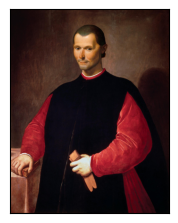

In [39]:
# Populate retrieved documents - texts and images
imgs = []
txts = []
for text_node in response.metadata["text_nodes"]:
    if text_node.text == '':
        imgs.append(text_node.metadata['file_path'].decode('utf-8'))
    else:
        txts.append(text_node.text)

# Display retrieved documents - texts and images
for txt in txts:
    print(txt)
show_images(imgs)